In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt

W0417 15:26:27.130201 140737237115840 deprecation_wrapper.py:76] From /anaconda3/envs/k_tfp/lib/python3.6/site-packages/tensorflow_probability/python/math/root_search.py:51: The name reduce_all is deprecated. Please use reduce_all instead.

W0417 15:26:27.132055 140737237115840 deprecation_wrapper.py:76] From /anaconda3/envs/k_tfp/lib/python3.6/site-packages/tensorflow_probability/python/bijectors/masked_autoregressive.py:412: The name nn.relu is deprecated. Please use nn.relu instead.

W0417 15:26:27.132992 140737237115840 deprecation_wrapper.py:76] From /anaconda3/envs/k_tfp/lib/python3.6/site-packages/tensorflow_probability/python/bijectors/masked_autoregressive.py:529: The name keras.layers.Layer is deprecated. Please use keras.layers.Layer instead.

W0417 15:26:27.220837 140737237115840 deprecation_wrapper.py:76] From /anaconda3/envs/k_tfp/lib/python3.6/site-packages/tensorflow_probability/python/edward2/random_variable.py:191: The name Tensor is deprecated. Please use Tensor inst

In [2]:
x = np.arange(-10, 50, 0.1)
y = np.sin(x)*x/20+np.random.randn(len(x))*x/50+5.0+0.1*x

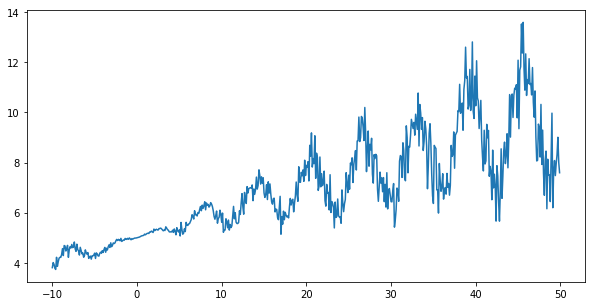

In [3]:
plt.figure(figsize = (10,5))
plt.plot(x, y)

In [4]:
x = np.array(x)
y = np.array(y)
x = x.reshape(x.shape[0],-1)
y = y.reshape(y.shape[0],-1)

x_test_idx = np.random.choice(list(range(len(x))), int(len(x)/5), replace = False)
x_test_idx=np.sort(x_test_idx)
x_tst = x[x_test_idx]
y_tst = y[x_test_idx]

x = x[[i for i in range(len(x)) if i not in x_test_idx]]
y = y[[i for i in range(len(y)) if i not in x_test_idx]]

In [5]:
negloglik = lambda y, p_y: -p_y.log_prob(y)


tfd = tfp.distributions

# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False)

# Make predictions.
yhat = model(x_tst)

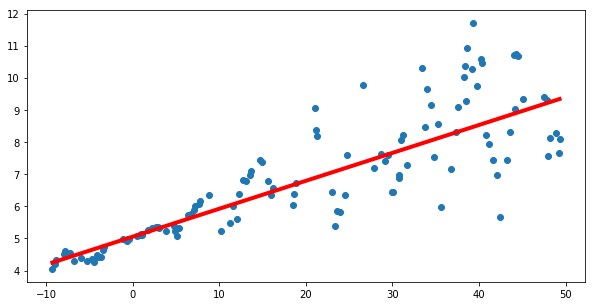

In [6]:
plt.figure(figsize = (10,5))
plt.scatter(x_tst, y_tst)
plt.plot(x_tst, yhat.mean(),linewidth=4.0, c='r')

In [7]:
negloglik = lambda y, p_y: -p_y.log_prob(y)


tfd = tfp.distributions

# Build model.
model = tf.keras.Sequential([
  tf.keras.layers.Dense(2),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(
      loc=t[..., :1],
      scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]))),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False)

# Make predictions.
yhat = model(x_tst)

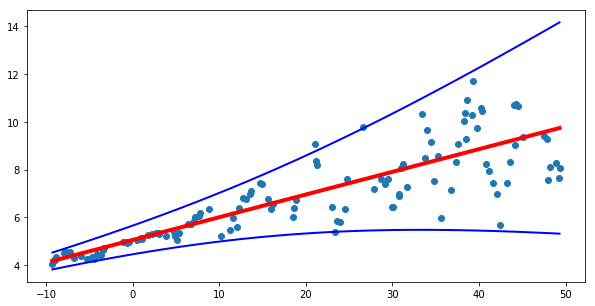

In [8]:
plt.figure(figsize = (10,5))
plt.scatter(x_tst, y_tst)
plt.plot(x_tst, yhat.mean(),linewidth=4.0, c='r')
plt.plot(x_tst, yhat.mean()+yhat.stddev()*1.96,linewidth=2.0, color='blue')
plt.plot(x_tst, yhat.mean()-yhat.stddev()*1.96,linewidth=2.0, color='blue')

In [9]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1))
    ])

In [10]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1))
    ])

In [11]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable),
  tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False)

# Make predictions.
yhats = [model(x_tst) for i in range(100)]

W0417 15:26:40.627753 140737237115840 deprecation_wrapper.py:76] From /anaconda3/envs/k_tfp/lib/python3.6/site-packages/tensorflow_probability/python/layers/dense_variational_v2.py:79: The name keras.regularizers.get is deprecated. Please use keras.regularizers.get instead.

W0417 15:26:40.630740 140737237115840 deprecation_wrapper.py:76] From /anaconda3/envs/k_tfp/lib/python3.6/site-packages/tensorflow_probability/python/layers/dense_variational_v2.py:88: The name keras.activations.get is deprecated. Please use keras.activations.get instead.

W0417 15:26:40.632197 140737237115840 deprecation_wrapper.py:76] From /anaconda3/envs/k_tfp/lib/python3.6/site-packages/tensorflow_probability/python/layers/dense_variational_v2.py:91: The name keras.layers.InputSpec is deprecated. Please use keras.layers.InputSpec instead.

W0417 15:26:40.639554 140737237115840 deprecation_wrapper.py:76] From /anaconda3/envs/k_tfp/lib/python3.6/site-packages/tensorflow_probability/python/layers/dense_variational

[[<matplotlib.lines.Line2D at 0x134777ef0>],

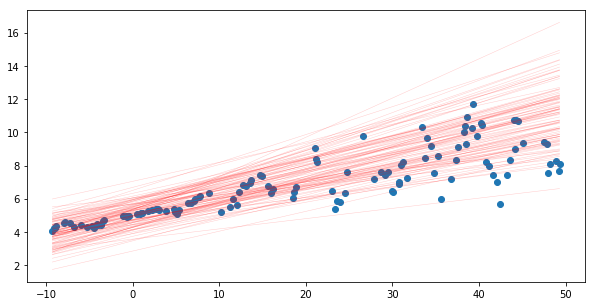

In [12]:
plt.figure(figsize = (10,5))
plt.scatter(x_tst, y_tst)
[plt.plot(x_tst, i.mean(),linewidth=0.5, c='r', alpha = 0.2) for i in yhats]

In [13]:
# Build model.
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable),
    tfp.layers.DistributionLambda(
        lambda t: tfd.Normal(
            loc=t[..., :1],
            scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))
    ),
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False);

# Make predictions.
yhats = [model(x_tst) for i in range(100)]

[[<matplotlib.lines.Line2D at 0x135b65128>],

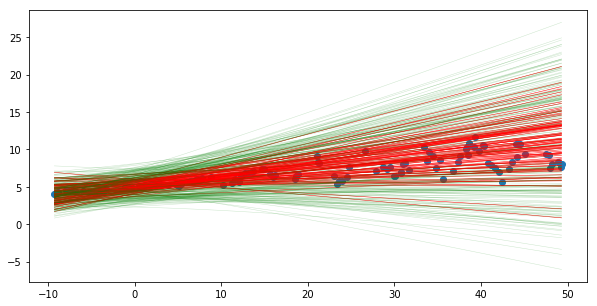

In [14]:
plt.figure(figsize = (10,5))
plt.scatter(x_tst, y_tst)
[plt.plot(x_tst, i.mean(),linewidth=0.5, c='r') for i in yhats]
[plt.plot(x_tst, i.mean()+i.stddev()*1.96,linewidth=0.5, c='g',alpha=0.2) for i in yhats]
[plt.plot(x_tst, i.mean()-i.stddev()*1.96,linewidth=0.5, c='g',alpha=0.2) for i in yhats]

In [15]:
#@title Custom PSD Kernel
class RBFKernelFn(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(RBFKernelFn, self).__init__(**kwargs)
        dtype = kwargs.get('dtype', None)

        self._amplitude = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='amplitude')

        self._length_scale = self.add_variable(
            initializer=tf.constant_initializer(0),
            dtype=dtype,
            name='length_scale')

    def call(self, x):
    # Never called -- this is just a layer so it can hold variables
    # in a way Keras understands.
        return x

    @property
    def kernel(self):
        return tfp.positive_semidefinite_kernels.ExponentiatedQuadratic(
            amplitude=tf.nn.softplus(0.1 * self._amplitude),
            length_scale=tf.nn.softplus(5. * self._length_scale)
        )

In [16]:
# Build model.
num_inducing_points = 40
x_range = (-10,50)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[1], dtype=x.dtype),
    tf.keras.layers.Dense(1, kernel_initializer='ones', use_bias=False),
    tfp.layers.VariationalGaussianProcess(
        num_inducing_points=num_inducing_points,
        kernel_provider=RBFKernelFn(dtype=x.dtype),
        event_shape=[1],
        inducing_index_points_initializer=tf.constant_initializer(
            np.linspace(*x_range, num=num_inducing_points,
                        dtype=x.dtype)[..., np.newaxis]),
        unconstrained_observation_noise_variance_initializer=(
            tf.constant_initializer(np.array(0.54).astype(x.dtype))),
    ),
])

# Do inference.
batch_size = 32
loss = lambda y, rv_y: rv_y.variational_loss(
    y, kl_weight=np.array(batch_size, x.dtype) / x.shape[0])
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=loss)
model.fit(x, y, batch_size=batch_size, epochs=2000, verbose=False)

yhat = model(x_tst)

W0417 15:27:10.897615 140737237115840 deprecation_wrapper.py:76] From /anaconda3/envs/k_tfp/lib/python3.6/site-packages/tensorflow_probability/python/layers/distribution_layer.py:1794: The name nn.softplus is deprecated. Please use math.softplus instead.

W0417 15:27:10.962347 140737237115840 deprecation_wrapper.py:76] From /anaconda3/envs/k_tfp/lib/python3.6/site-packages/tensorflow_probability/python/positive_semidefinite_kernels/exponentiated_quadratic.py:114: The name math.squared_difference is deprecated. Please use math.squared_difference instead.

W0417 15:27:10.994090 140737237115840 deprecation_wrapper.py:76] From /anaconda3/envs/k_tfp/lib/python3.6/site-packages/tensorflow_probability/python/positive_semidefinite_kernels/exponentiated_quadratic.py:123: The name math.log is deprecated. Please use math.log instead.

W0417 15:27:11.446224 140737237115840 tf_logging.py:161] Using (possibly slow) default implementation of determinant.  Requires conversion to a dense matrix and O(N

[[<matplotlib.lines.Line2D at 0x137ecebe0>],

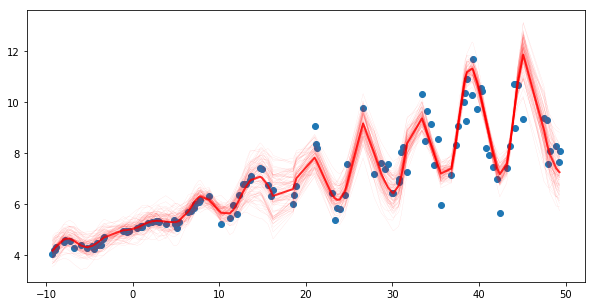

In [17]:
plt.figure(figsize = (10,5))
plt.scatter(x_tst, y_tst)
plt.plot(x_tst, yhat.mean(),linewidth=2, c='r', alpha = 0.8)
[plt.plot(x_tst, yhat.sample().numpy(),linewidth=0.2, c='r', alpha = 0.2) for i in range(100)]